# Milestone 01 — Data prep & plan  
### *Anatomy of Horror*

---

## Project overview

This project explores **horror as a cultural barometer**—capturing, distorting, and projecting our collective fears back to us.  
Using a sample of **4,000+ horror films from 1950–2024**, it examines what horror titles reveal about **contemporary anxieties** and how these evolve across changing contexts.

To do this, the data collection and analysis process will be divided into **four main phases**:


### Phase 1 — Intro: Locating horror in the broader genre landscape (2020-2024)

Before zooming into horror itself, we need to understand how the genre sits relative to others.
We will work with IMDb top 3,000 most voted movies for 2020-2024 and broadly look at each genre based on key metrics:

- IMDb total votes --> proxy for **audience engagement**
- IMDb average rating --> proxy for **prestige / critical reception**
- Total count of movies per genre

_Note 1: Each movie may belong to more than one genre. To capture the nature of each genre, multi-genre films will have full credit in every genre they belong to. Therefore, when aggregating data, totals across genres will exceed the number of unique films._
_Note 2: Why 2020–2024? IMDb vote counts grow cumulatively over time. Focusing on this recent 5-year window ensures that all genres have comparable exposue while still reflecting dynamics across several years rather than a single year (which is prone to specific biases)._



### Phase 2 — Main analysis: zooming into horror (1950–2024)
Once we visualize horror’s location in the genre landscape, we’ll expand the timeline to focus exclusively on horror films from 1950 to 2024.

#### - Step 1 — Data retrieval & cleaning
In this phase we will fetch and clean more than 4000 horror films from TMDb.
After collection, the dataset has to be preprocessed by :
- Parsing and normalizing release dates
- Removing duplicates and incomplete records
- Computing decade fields (1950s, 1960s, …) for analysis

_Note: Because older decades have fewer movies, we can use weighted sampling to ensure we have representative samples for each decade._

#### - Step 2 — LLM-Assisted alassification: mapping fears
The cleaned dataset is then passed to an LLM-based classification stage.
Each film’s title, overview, and keywords are analyzed by a model (run locally via ollama) to infer the movie’s dominant menace.

_Note: The classification should be followed by an assessment of the accuracy of the model in comparison to manual classification. This will have to be specified in any further analysis._



### Phase 3 — Label parsing & analysis (1950–2024):
We will then import the LLM output. This will be followed by:
- Parsing a single canonical fear label from each LLM response
- Analyzing counts and shares for the categories defined
- Analyzing how the relative share of each fear type changes across time, region, and potentially gender

_Optional focus: restrict the analysis to one country and contextualize findings with specific historical data (e.g., migration, conflict, or economic data)._



### Phase 4 — Poster clustering
The goal of this phase is to explore the film posters and analyze their visual features to examine if we can meaningfully cluster them testing several techniques.

We will:
- Fetch and store the posters locally
- Test different methods / models to cluster them based on visual patterns
- Check whether the clusters correlate with countries, decades, or fear categories

\
\
Now we can get started.







In [113]:
# PHASE 1


# ======================
# Configuration: This section defines all the global settings and file paths used in the pipeline.
# ======================

# --- library imports ---
import os      
import re   
from pathlib import Path 
import json    # read/write cache files (e.g., IMDb-to-TMDb ID mappings)
import time    # delays between API calls (so we don't hit rate limits)
import pandas as pd
import requests      # to make requests to TMDb API
from requests.adapters import HTTPAdapter  # add retry logic
from urllib3.util.retry import Retry       # to configure retry behavior
from tqdm import tqdm                      # progress bar for loops

# --- API configuration ---
TMDB_API_KEY = "d80e910f0022b20de3e4124c7444712c"
# base URL for all TMDb API endpoints
TMDB_BASE    = "https://api.themoviedb.org/3"

# --- input file paths ---
# IMDb periodically releases public tsv (tab-separated values) datasets (https://datasets.imdbws.com/) with metadata and ratings for all IMDb titles
IMDB_DIR   = Path("imdb_dumps")                    # root folder where IMDb dumps are stored
BASICS_GZ  = IMDB_DIR / "title.basics.tsv.gz"      # contains titles, years, and genre info
RATINGS_GZ = IMDB_DIR / "title.ratings.tsv.gz"     # contains average ratings and vote counts

# --- filtering parameters ---
WINDOW_START, WINDOW_END = 2020, 2024
# we take the top 3,000 ranked by number of votes ("hits" population.)
TOP_K = 3000

# --- output directories ---
# all generated CSVs and caches will be saved here:
OUT_DIR = Path("hits_2020_2024_imdb_tmdb")
# the 'parents=True' argument allows creation of folders
# 'exist_ok=True' avoids errors if the folder already exists.
OUT_DIR.mkdir(parents=True, exist_ok=True)


# --- output file paths ---
# these are the files that we will then use to examine the results:
MASTER_CSV = OUT_DIR / "master_2020_2024_tmdb_imdb.csv"
JOINED_CSV = OUT_DIR / "joined_with_imdb.csv"  #   → joined dataset combining IMDb votes/ratings with TMDb genres.

# --- cache file ---
# to avoid asking the TMDb API repeatedly for the same IMDb IDs,
# we store a local mapping between IMDb ids (e.g., 'tt1234567') and TMDb ids (integer)
# on subsequent runs, the script will use this file instead of refetching:
MAP_CACHE = OUT_DIR / "imdb_to_tmdb_map.json"

In [114]:
# ======================
# HTTP session + helper functions
# ======================
# the TMDb API is rate-limited and can sometimes return errors (like "too many requests").
# we need to set up a polite requests.Session with retry logic to ensure that:
#   • temporary connection issues don’t crash the script.
#   • we respect TMDb’s rate limits by adding a small delay (0.25s) between requests.

def make_session() -> requests.Session:
    """
    Creates a persistent HTTP session with retry logic.
    Returns:
        requests.Session — a session object configured for safe repeated API calls.
    """
    s = requests.Session()  # persistent connection

    # Configure retry policy:
    retry = Retry(
        total=5,                # maximum total retry attempts before failing completely
        connect=3,              # retry up to 3 times on connection errors
        read=3,                 # retry up to 3 times on read timeouts
        backoff_factor=1.2,     # exponential delay: wait 1.2s, then 2.4s, etc. between retries
        status_forcelist=[429, 500, 502, 503, 504],  # retry only for these HTTP status codes
        allowed_methods={"GET"},  # retry only GET requests (safe + idempotent)
        raise_on_status=False     # don't raise an exception automatically
    )

    # attach retry policy to all HTTPS requests made through this session
    s.mount("https://", HTTPAdapter(max_retries=retry))

    return s  # return the configured session ready for use

# instantiate a single shared session, this will be reused across all TMDb API calls:
SESSION = make_session()


def tmdb_get(path: str, params: dict) -> dict:
    """
    A helper function to perform a GET request to the TMDb API safely.

    Args:
        path (str): Endpoint path, e.g., "/find/tt1234567"
        params (dict): Query parameters for the API call.

    Returns:
        dict: Parsed JSON response if successful, otherwise an empty dict.
    """

    # --- construct the full URL for the endpoint ---
    # stripping slashes to avoid accidental double slashes (//) in the URL
    url = f"{TMDB_BASE.rstrip('/')}/{path.lstrip('/')}"

    # --- add the API key to the request parameters ---
    p = {**(params or {}), "api_key": TMDB_API_KEY}

    # --- perform the GET request ---
    # timeout=(5, 30) defines how long Python will wait before giving up (wait up to 5 seconds to connect, then 30 seconds to get a full response after the connection succeeds)
    r = SESSION.get(url, params=p, timeout=(5, 30))

    # sleep for 0.25 seconds between calls to avoid rate-limiting
    time.sleep(0.25)

    # --- handle the response ---
    # if successful (status 200), return the parsed JSON response
    # otherwise, return an empty dict
    return r.json() if r.status_code == 200 else {}


In [115]:
# ======================
# Map IMDb → TMDb IDs
# ======================
# IMDb and TMDb use different internal identifiers for the same movies.
#   • IMDb IDs look like "tt0111161"
#   • TMDb IDs are numeric
#
# this function bridges those two systems using TMDb’s `/find/{imdb_id}` endpoint:
# it takes a list of IMDb IDs, queries TMDb to find their corresponding TMDb IDs,
# and writes the results to a local JSON cache file for reuse in future runs.
# Once we have a mapping, we can fetch full TMDb metadata for every movie.

def imdb_to_tmdb_ids(imdb_ids):
    """
    Maps a list of IMDb title IDs (e.g., 'tt1234567') to their corresponding TMDb IDs (integers).
    If a local cache exists, it will load and reuse it, updating only missing entries.

    Args:
        imdb_ids (list[str]): List of IMDb IDs to resolve.

    Returns:
        dict: Mapping of { "tt1234567": 456, "tt7654321": None, ... }
              where `None` indicates no TMDb match was found.
    """

    # --- step 1: initialize the cache dictionary ---
    # it first tries to read any previously saved mappings from MAP_CACHE
    cache = {}
    if MAP_CACHE.exists():  # if the cache file already exists from a prior run
        try:
            cache = json.loads(MAP_CACHE.read_text())  # load as Python dict
        except Exception:
            # if the cache file is corrupted or unreadable, start with an empty one
            cache = {}

    # --- step 2: copy the existing cache into a working dictionary ---
    out = dict(cache) # 'out' will be the final combined dictionary

    # --- step 3: identify IMDb IDs that still need to be resolved ---
    # we only query TMDb for new IDs not already present in the cache
    to_do = [tt for tt in imdb_ids if tt not in out]

    # --- step 4: query TMDb’s `/find/{imdb_id}` endpoint for each missing ID ---
    # each request asks TMDb to locate the corresponding movie record using the IMDb ID
    # example API call: GET https://api.themoviedb.org/3/find/tt1234567?external_source=imdb_id
    for tt in tqdm(to_do, desc="Resolving IMDb → TMDb", unit="tt"):
        # make the API request
        data = tmdb_get(f"/find/{tt}", {"external_source": "imdb_id"})

        # parse the JSON response
        # the result structure looks like:
        # {
        #   "movie_results": [ {"id": 278, "title": "...", ...} ],
        #   "tv_results": [],
        #   "person_results": []
        # }
        mv = data.get("movie_results") or []

        # if there is at least one movie result and it has an "id" field, store it
        # otherwise, record None
        out[tt] = int(mv[0]["id"]) if mv and mv[0].get("id") else None

    # --- step 5: Save the updated mapping ---
    # this ensures that the next time the script runs, it can skip resolved IDs.
    MAP_CACHE.write_text(json.dumps(out))

    # --- step 6: Return the full mapping dictionary ---
    return out


In [116]:
# ======================
# 🎞️ Fetch TMDb details
# ======================
# after mapping IMDb IDs to TMDb IDs, this function fetches detailed metadata
# for each movie directly from TMDb’s `/movie/{id}` endpoint.
# Workflow:
#  1. iterate through the list of TMDb IDs
#  2. fetch each movie’s metadata using the `/movie/{id}` endpoint
#  3. extract relevant fields and append them to a list of dictionaries
#  4. return a dataframe containing all fetched movie details

def fetch_tmdb_details_for_ids(tmdb_ids):
    """
    Fetches detailed movie metadata from TMDb for a list of movie IDs.

    Args:
        tmdb_ids (list[int]): List of TMDb numeric IDs for the movies to query.

    Returns:
        pd.DataFrame: A table with one row per movie, containing TMDb + IMDb metadata.
    """

    # initialize a container for the collected movie records.
    rows = []

    # --- loop through each TMDb ID and fetch its data ---
    # tqdm gives a live progress bar to monitor download progress
    for mid in tqdm(tmdb_ids, desc="Fetching TMDb details", unit="movie"):
        
        # API request:
        # we query the /movie/{id} endpoint for this specific TMDb ID.
        # we also ask TMDb to include ("append") the `external_ids` block,
        # which contains the movie’s IMDb ID — needed later for merging.
        d = tmdb_get(
            f"/movie/{mid}",
            {
                "language": "en-US",  # ensures all fields are returned in English
                "append_to_response": "external_ids"  # includes IMDb id
            }
        )

        if not d:
            continue

        # extract genre information:
        # the "genres" field is a list of dicts, each with {"id": ..., "name": ...}.
        genres_block = d.get("genres") or []
        # we extract only the names (e.g. "Horror", "Drama")
        # and join them into a comma-separated string for later parsing
        genre_names = ", ".join([
            g["name"]
            for g in genres_block
            if isinstance(g, dict) and g.get("name")
        ])

        # extract external identifiers (to reconnect back to IMDb)
        ext = d.get("external_ids") or {}

        # append relevant fields to our list
        rows.append({
            "tmdb_id": mid,                                # TMDb’s internal numeric ID
            "imdb_id": ext.get("imdb_id"),                 # IMDb ID (for cross-dataset joins)
            "title": d.get("title"),                       # localized title
            "original_title": d.get("original_title"),     # original title (if different)
            "original_language": d.get("original_language"),  # ISO-639-1 language code
            "overview": d.get("overview"),                 # plot summary (useful later for NLP)
            "poster_path": d.get("poster_path"),           # partial path to poster image
            "release_date": (d.get("release_date") or "").strip(),  # release date string (YYYY-MM-DD)
            "genres_tmdb_names": genre_names,              # comma-separated list of genres
            "runtime": d.get("runtime"),                   # duration in minutes
            "revenue": d.get("revenue"),                   # box-office revenue (USD)
            "popularity_tmdb": d.get("popularity"),        # TMDb’s internal popularity metric
        })

    # after fetching all entries, convert the list of dicts into a pandas dataframe
    return pd.DataFrame(rows)


In [117]:
# ======================
# orchestrate Phase 1 end-to-end
# ======================
# tie together all previous steps to produce the two key outputs:
#   1) MASTER_CSV  → TMDb master table (movie-level details keyed by tmdb_id)
#   2) JOINED_CSV  → joined table (TMDb details + IMDb signals)
#
# Process:
#   1. build base IMDb set (2020–2024, top 3000 by numVotes)
#   2. map IMDb → TMDb, keep only resolved rows
#   3. build (or resume) TMDb master
#   4. join IMDb ratings/votes onto TMDb master
#   5. clean/filter and save the joined table

def main(force: bool = False):
    """Build MASTER_CSV (TMDb details) and JOINED_CSV (TMDb + IMDb signals)."""

    # early exit if final artifact already exists
    if JOINED_CSV.exists() and not force:
        print(f"[SKIP] {JOINED_CSV} already exists — nothing to do. (use force=True to rebuild)")
        return

    # -----------------------------
    # 1. base set (2020–2024 top 3000 + small buffer)
    # -----------------------------
    imdb_df = load_imdb_window(buffer=100)  # over-fetch by 100 to cover unmapped titles
    tt_list = imdb_df["tconst"].astype(str).tolist()

    # -----------------------------
    # 2. resolve ids and keep only those with TMDb matches
    # -----------------------------
    mapping = imdb_to_tmdb_ids(tt_list)
    imdb_df["tmdb_id"] = imdb_df["tconst"].map(mapping)
    resolved = imdb_df[imdb_df["tmdb_id"].notna()].copy()
    resolved["tmdb_id"] = pd.to_numeric(resolved["tmdb_id"], errors="coerce").astype("Int64")

    # re-sort by votes and trim back to TOP_K
    resolved = (
        resolved.sort_values("numVotes", ascending=False)
                .head(TOP_K)
                .reset_index(drop=True)
    )
    print(f"[INFO] Resolved TMDb ids: {len(resolved)} / {len(imdb_df)} (trimmed to TOP_K={TOP_K})")

    # -----------------------------
    # 3. build or update TMDb master
    # -----------------------------
    if MASTER_CSV.exists():
        master = pd.read_csv(MASTER_CSV)
        have = set(pd.to_numeric(master["tmdb_id"], errors="coerce").dropna().astype(int))
        need = list(set(resolved["tmdb_id"].dropna().astype(int)) - have)
        print(f"[INFO] TMDb master has {len(master)} rows; missing {len(need)} ids.")
        new = fetch_tmdb_details_for_ids(need) if need else pd.DataFrame()
        if not new.empty:
            master = (pd.concat([master, new], ignore_index=True)
                        .drop_duplicates(subset=["tmdb_id"]))
            master.to_csv(MASTER_CSV, index=False)
            print(f"[OK] Updated {MASTER_CSV} (+{len(new)} rows).")
    else:
        master = fetch_tmdb_details_for_ids(resolved["tmdb_id"].dropna().astype(int).tolist())
        master.to_csv(MASTER_CSV, index=False)
        print(f"[OK] Wrote {MASTER_CSV} ({len(master)} rows).")

    # -----------------------------
    # 4. join IMDb to TMDb master
    # -----------------------------
    # helper to ensure a 'tmdb_id' column exists (this is because when joining or merging in pandas, column names can get renamed automatically (e.g., tmdb_id_x, tmdb_id_y))
    def ensure_tmdb_id(df, candidates):
        if "tmdb_id" not in df.columns:
            for c in candidates:
                if c in df.columns:
                    df["tmdb_id"] = pd.to_numeric(df[c], errors="coerce")
                    break
        if "tmdb_id" not in df.columns:
            raise KeyError("tmdb_id not found in columns: " + ", ".join(map(str, df.columns)))

    # normalize tmdb_id presence
    ensure_tmdb_id(master,  ["tmdb_id_tmdb", "tmdb_id_x", "tmdb_id_y", "id"])
    ensure_tmdb_id(resolved, ["tmdb_id_imdb", "tmdb_id_x", "tmdb_id_y"])

    # make imdb_id comparable on both sides
    master["imdb_id"]   = master["imdb_id"].astype(str)
    resolved["imdb_id"] = resolved["tconst"].astype(str)

    # build a list of columns that actually exist in resolved
    resolved_cols = [
        c for c in [
            "imdb_id", "averageRating", "numVotes",
            "primaryTitle", "originalTitle", "genres",
            "startYear", "tmdb_id"
        ] if c in resolved.columns
    ]

    # merge
    joined = master.merge(
        resolved[resolved_cols],
        on="imdb_id",
        how="left",
        suffixes=("_tmdb", "_imdb")
    )

    # after merge, guarantee a 'tmdb_id' column on joined
    if "tmdb_id" not in joined.columns:
        # pull from master side if resolved didn't carry it
        for alt in ["tmdb_id_tmdb", "tmdb_id_x", "tmdb_id_y", "id"]:
            if alt in joined.columns:
                joined["tmdb_id"] = pd.to_numeric(joined[alt], errors="coerce")
                break
    else:
        # if both existed, prefer the master id when available
        if "tmdb_id_tmdb" in joined.columns:
            joined["tmdb_id"] = joined["tmdb_id"].fillna(pd.to_numeric(joined["tmdb_id_tmdb"], errors="coerce"))

    # -----------------------------
    # 5. clean/filter and save the joined table
    # -----------------------------
    joined = joined[pd.to_numeric(joined["tmdb_id"], errors="coerce").notna()].copy()
    joined["tmdb_id"] = joined["tmdb_id"].astype(int)

    joined = joined[
        pd.to_numeric(joined["startYear"], errors="coerce")
          .between(WINDOW_START, WINDOW_END, inclusive="both")
    ].copy()

    joined.to_csv(JOINED_CSV, index=False)
    print(f"[OK] Wrote {JOINED_CSV} ({len(joined)} rows, {len(joined.columns)} cols).")



In [118]:
# ======================
# load IMDb dataset and select 2020–2024 "hits"
# ======================
# Purpose: build a base dataframe with the top 3,000 movies by IMDb vote count within the target window (2020–2024)

def load_imdb_window(buffer: int = 100) -> pd.DataFrame:
    """
    Loads and filters IMDb datasets to return the top-(K + buffer) movies (by number of votes)
    released between WINDOW_START and WINDOW_END. We over-fetch by `buffer`
    so that after resolving IMDb→TMDb we can trim back to exactly TOP_K.

    Returns:
        pd.DataFrame: titles + ratings for 2020–2024 hits (TOP_K + buffer rows).
    """
    # --- load IMDb basics: ids, title type, titles, year, genres ---
    basics = pd.read_csv(
        BASICS_GZ,
        sep="\t",                # IMDb dumps are TSV
        na_values="\\N",         # IMDb uses "\N" for missing
        low_memory=False,        # to read the whole file first before inferring data types (slower but more consistent)
        usecols=[
            "tconst",            # IMDb ID (e.g., tt1234567)
            "titleType",         # 'movie', 'tvSeries', etc.
            "primaryTitle",      # display title
            "originalTitle",     # original title
            "startYear",         # release year
            "genres"             # comma-separated
        ],
    )

    # --- load IMDb ratings: averageRating + numVotes ---
    ratings = pd.read_csv(
        RATINGS_GZ,
        sep="\t",
        na_values="\\N",
        usecols=["tconst", "averageRating", "numVotes"],
    )

    # --- year filter: keep only feature films in 2020–2024 ---
    basics["startYear"] = pd.to_numeric(basics["startYear"], errors="coerce")
    movies = basics[
        (basics["titleType"] == "movie") &
        (basics["startYear"].between(WINDOW_START, WINDOW_END, inclusive="both"))
    ].copy()

    # --- join ratings, drop rows missing core signals ---
    df = (
        movies.merge(ratings, on="tconst", how="inner")
              .dropna(subset=["numVotes", "averageRating"])
    )

    # --- rank by numVotes and keep TOP_K + buffer titles ---
    take = TOP_K + int(buffer or 0)
    df = df.sort_values("numVotes", ascending=False).head(take).reset_index(drop=True)

    print(f"[INFO] IMDb windowed set → {len(df)} rows (top {TOP_K} + buffer {buffer}).")
    return df



In [119]:
# Running the main function to execute the pipeline
main()

[SKIP] hits_2020_2024_imdb_tmdb/joined_with_imdb.csv already exists — nothing to do. (use force=True to rebuild)


In [120]:
# ======================
# Summary per genre
# ======================
# per-genre summary before plotting, with the following metrics:
#   • avg_rating             → mean IMDb rating across movies in the genre
#   • total_popularity_votes → total IMDb votes across movies in the genre (overall engagement proxy)
#   • n_unique_titles        → number of distinct movies contributing to that genre
#
# note: we will use full credit for multi-genre films (explode and count each genre separately)

def split_genres(s: str):
    """Split a comma-separated TMDb genre string into a clean list."""
    if not isinstance(s, str) or not s.strip():
        return []
    return [g.strip() for g in s.split(",") if g.strip()]

# --- load joined table from orchestration step ---
joined = pd.read_csv(JOINED_CSV)

# copy to dataframe
df = joined.copy()

# ensure numeric types for safe aggregation
df["averageRating"] = pd.to_numeric(df["averageRating"], errors="coerce")
df["numVotes"]      = pd.to_numeric(df["numVotes"], errors="coerce").fillna(0)

# build list of genres, then explode (full credit per genre)
df["genre"] = df["genres_tmdb_names"].apply(split_genres)
df = df.explode("genre").dropna(subset=["genre"])

# --- aggregate per-genre ---
genre_hit = (
    df.groupby("genre", as_index=False)
      .agg(
          avg_rating=("averageRating", "mean"),
          total_popularity_votes=("numVotes", "sum"),
          n_unique_titles=("tmdb_id", "nunique")
      )
      .sort_values("total_popularity_votes", ascending=False)
)

# --- save ---
out_path = OUT_DIR / "genre_hit_matrix_2020_2024.csv"
genre_hit.to_csv(out_path, index=False)
print(f"[OK] Wrote per-genre summary → {out_path}  ({len(genre_hit)} genres)")

# checking top 10 genres
print(genre_hit.head(10))


[OK] Wrote per-genre summary → hits_2020_2024_imdb_tmdb/genre_hit_matrix_2020_2024.csv  (19 genres)
              genre  avg_rating  total_popularity_votes  n_unique_titles
6             Drama    6.490182                41677072             1426
0            Action    5.969231                39446675              702
16         Thriller    5.905956                33015636              957
3            Comedy    6.185666                31576520              886
1         Adventure    6.188162                27991340              321
14  Science Fiction    5.869686                22184824              287
10           Horror    5.541454                17242063              509
4             Crime    6.217824                16970079              432
8           Fantasy    6.286220                13759170              254
13          Romance    6.187050                10930888              417


In [ ]:
# PHASE 2
# In this phase, we leave the cross-genre perspective and focus exclusively on horror films.  
# Our goal is to create a much larger dataset that will allow us to study the evolution of fears across time, regions, and contexts.

# Because this process requires both heavy API calls and local LLM inference, it was executed in a Google Colab environment.


# PHASE 2 - Step 1: Data retrieval & cleaning (1950–2024)
# We will:
# 1. Fetch ALL titles tagged with the Horror genre (ID = 27), using its /discover/movie endpoint.
# 2. Pre-process and clean the data to ensure consistency (dates, duplicates, missing values).
# 3. Group and sample by decade to maintain proportional representation — since older decades have fewer entries.  

# Note: The current sampling strategy is the following:
#   • Each decade (1950–2020) receives a base quota of 300 films.
#   • The remaining slots of the target total (5,000) are distributed proportionally to each decade’s output.
#   • Within each decade, we select the most popular titles (by TMDb popularity) as proxies for cultural visibility.
# This balances early underrepresented decades with later data-rich ones.


### PHASE 2 — Step 2: LLM-Assisted Fear Classification (1950–2024)
# Having built a decade-balanced horror dataset, we now infer each film’s dominant fear/menace using an LLM (run locally via ollama).
# We classify each movie into one of our 11, theory-informed categories based on title, synopsis, and keywords.
# This step runs in Google Colab for speed and local-model hosting (LLaMA 3 8B, run locally through Ollama).

# Note: This is the classification prompt we use:
def create_classification_prompt(title, synopsis, keywords):
    """
    Build a STRICT single-label classification prompt for horror fears.
    It instructs the model to choose exactly ONE category that best captures
    the *primary* menace structuring the film’s horror.
    """
    prompt_template = """You are a horror film analyst. Your task is to classify a movie into one thematic fear category based on its title, overview, keywords, and cultural and cinematic knowledge consistent with the film’s premise.

Your goal is to select ONLY ONE category that best represents the PRIMARY fear at the core of the film.
If multiple fears appear, choose the one that most directly structures the horror sequences — i.e., the fear that drives the menace or conflict.
Distinguish agency (intentional attackers or sentient invaders) from condition (disease, technology malfunction, isolation, or moral guilt).

CHOOSE FROM THE FOLLOWING 11 FEAR CATEGORIES:

1.  **Invasion & Paranoia** – Fear of being replaced, infiltrated, or observed by hidden others — aliens, doppelgängers, or unseen conspirators. Use ONLY when control comes from an **external or uncanny presence (human or inhuman), NOT from institutions, technologies, or social systems.** If the invading presence primarily alters biology or environment without conscious intent, classify instead under Body Horror or Contagion & Mutation.
    (e.g., **Invasion of the Body Snatchers**, **The Thing**, **Us**, **They Live**)

2.  **Persecution & Social Breakdown** – Fear of collective madness, mob violence, cult domination, vigilantism, or the collapse of moral order (curfew, purge, martial law). When mindless hordes (e.g., zombies) primarily depict **social decay rather than conscious replacement**, choose this over Invasion.
    (e.g., **The Wicker Man**, **The Purge: Anarchy**, **Midsommar**, **Train to Busan**)

3.  **Institutional & Structural Control** – Fear of systemic domination and engineered loss of agency.If the manipulation or loss of agency is engineered by social, racial, patriarchal, or economic power systems (even if it involves hypnosis, surgery, or technology), classify here — not as Possession. Use when control operates through systems or hierarchies rather than a single villain or invader. If the menace is structural (e.g., racialized, patriarchal, or corporate exploitation), route here — even if the surface resembles home invasion or mind control (e.g. Get Out).
    (e.g., **The Stepford Wives**, **The Crazies**, **Cam**, **1984**, **Get Out**)

4.  **Possession & Loss of Agency** – Fear of losing control of one’s mind or body to a supernatural or psychological force (demonic, psychic, or mind-control). Exclude biological infection (see Contagion & Mutation). If grief, legacy, or family lineage drives the horror, prefer Grief & Familial Trauma. If manipulation operated through systemic exploitation (racial, patriarchal, or institutional), do not classify as Possession — prefer Institutional & Structural Control.
    (e.g., **The Exorcist**, **The Evil Dead**, **Paranormal Activity**, **Get Out**)

5.  **Captivity & Voyeuristic Sadism** – Fear of imprisonment and deliberate cruelty as spectacle (traps, “games,” sadistic captors, sexual aggressors, or torturers). Choose this only when there is an **intentional, conscious captor** inflicting pain or coercive “game” design as the core engine. If confinement exists without a sadistic agent, prefer another category.
    (e.g., **Saw**, **Hostel**, **Martyrs**, **The Human Centipede 2**)

6.  **Contagion & Mutation** – Fear of infection, plague, parasitism, or involuntary biological transformation caused by **non-sentient agents** (virus, toxin, parasite, pandemics). Exclude demonic, psychic, or technological takeover.
    (e.g., **The Fly**, **28 Days Later**, **Cabin Fever**, **Slither**)

7.  **Body Horror** – Fear of bodily invasion, forced metamorphosis, dismemberment, surgical modification, or technological intrusion that compromises the body’s boundaries. Use when transformation is **inflicted or self-inflicted**, not the result of infection or contagion.
    (e.g., **Videodrome**, **Tusk**, **The Brood**, **Society**)

8.  **Ecological / Natural Menace** – Fear of nature turning hostile: animals, plants, weather, landscape, or the planet itself (non-sentient threat). If the threat is an animal (like sharks or other predators), insects, plant, weather phenomenon, always classify here.
    (e.g., **The Birds**, **Jaws**, **The Happening**, **The Ruins**)

9.  **Isolation & Psychological Unraveling** – Fear that arises when solitude or disconnection itself becomes the menace. The horror stems from being cut off — physically, socially, or existentially — until perception and sanity deteriorate. Use when there is *no conscious captor, infection, or systemic control*: only the gradual erosion of the self through loneliness, paranoia, or loss of meaning.
    (e.g., **The Shining**, **The Lighthouse**, **Moon**, **The Others**, **The Descent**, **The Mist**)

10.  **Grief & Familial Trauma** – Horror rooted in loss, inheritance, or haunted domestic bonds (bereavement, family curse, lineage). Choose this when **resurrection, haunting, or possession arises from grief or family legacy, not demonic manipulation.** If guilt, sin, or divine punishment are the central cause of horror, classify under Transgression & Moral Punishment instead.
    (e.g., **Hereditary**, **The Babadook**, **The Orphanage**, **Pet Sematary**)

11.  **Transgression & Moral Punishment** – Fear of violating sacred or moral boundaries, or of inner corruption that demands supernatural retribution or purification. Horror arises from sin, guilt, or desecration that provokes a curse, haunting, or ritual cleansing.
    (e.g., **The Witch**, **Drag Me to Hell**, **The Ring**, **Evil Dead Rise**, **Saint Maud**, **The Exorcism of Emily Rose**)

---
MOVIE DETAILS:
Title: {title}
Overview: {synopsis}
Keywords: {keywords}

---
YOUR RESPONSE:
"""
    return prompt_template.format(title=title, synopsis=synopsis, keywords=keywords)

In [122]:
# PHASE 3

# this step uses the CSV produced in Phase 2 (LLM classifications), extracts a single canonical category from the raw LLM response, 
# and produces a few quick looks (counts, stacked shares by decade, per-category trends)

# ======================
# imports and paths
# ======================
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# input and output paths
RAW_LLM_CSV        = "horror_data/horror_categorized_FULLSAMPLE.csv"            # Phase 2 output
CLEAN_FILTERED_CSV = "horror_data/horror_categorized_FULLSAMPLE_clean_filtered.csv"  # after parsing label

# column names used
RESP_COL   = "LLM_Raw_Response"   # raw LLM free text
CAT_COL    = "Fear_Category"      # parsed canonical label we’ll create
DECADE_COL = "decade"             # decade (e.g., 1950, 1960, ...)


# ======================
# parse LLM responses to extract canonical category
# ======================
# the LLM mentions the chosen category first and within double asterisks,
# so we extract the first occurrence between **...**. If nothing matches, we fall back to "Parsing Failed" to check those cases later.

def parse_category_from_response(response: str) -> str | None:
    """
    Extract the first **bolded** segment from the model response.
    Returns:
        - The inner text of the first **...** block, stripped, if found
        - "Parsing Failed" if response is a string but lacks the pattern
        - None if response is not a string (e.g., NaN)
    """
    if not isinstance(response, str):
        return None
    m = re.search(r"\*\*(.*?)\*\*", response, flags=re.DOTALL)
    return m.group(1).strip() if m else "Parsing Failed"

# Load Phase-2 output and parse the label into a new column
df = pd.read_csv(RAW_LLM_CSV)
df[CAT_COL] = df[RESP_COL].apply(parse_category_from_response)

# Quick parse report
failed = (df[CAT_COL] == "Parsing Failed").sum()
missing = df[CAT_COL].isna().sum()
print(f"Parsed OK: {len(df) - failed - missing:,} | Parsing Failed: {failed:,} | Missing: {missing:,}")

# Save the “clean” (parsed) file
df.to_csv(CLEAN_CSV, index=False)
print(f"Wrote parsed file → {CLEAN_CSV}")

Parsed OK: 5,737 | Parsing Failed: 0 | Missing: 0
Wrote parsed file → horror_data/horror_categorized_FULLSAMPLE_clean.csv


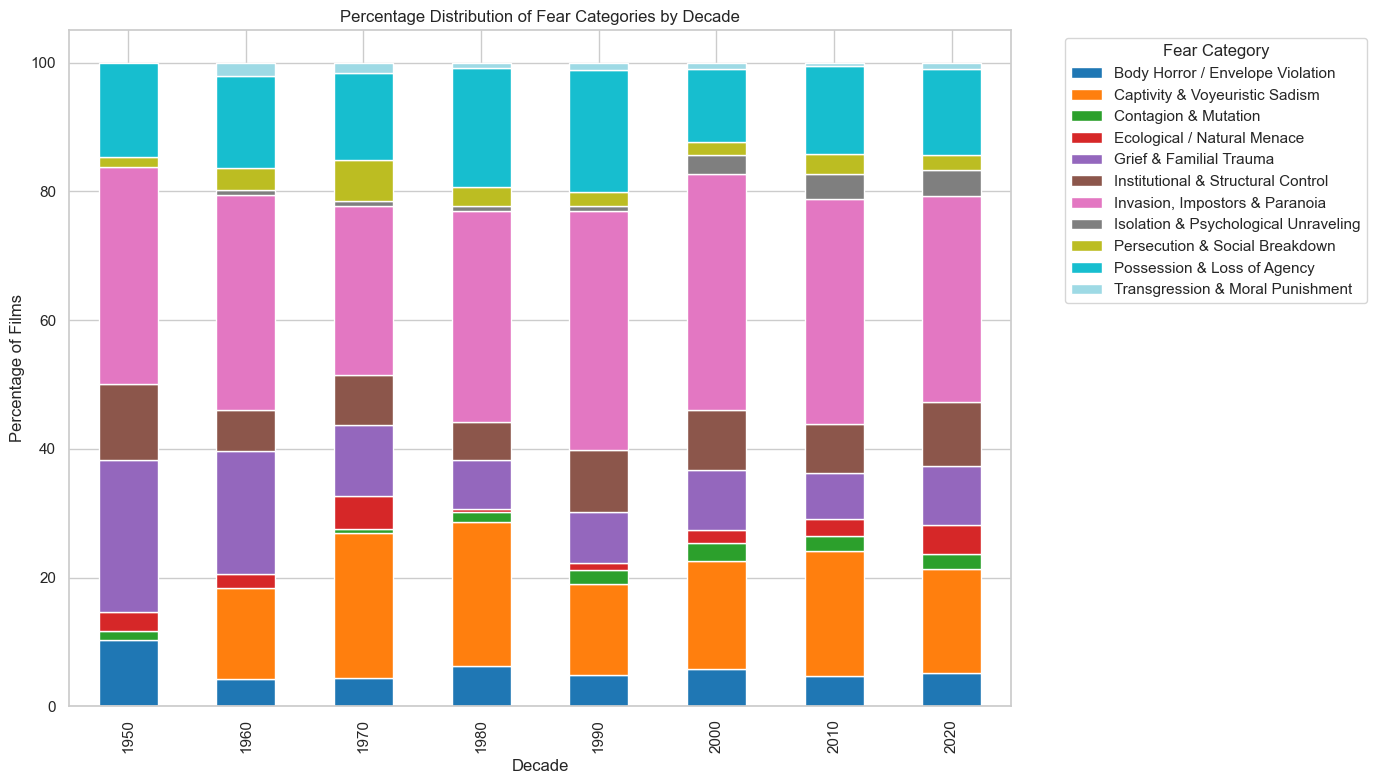

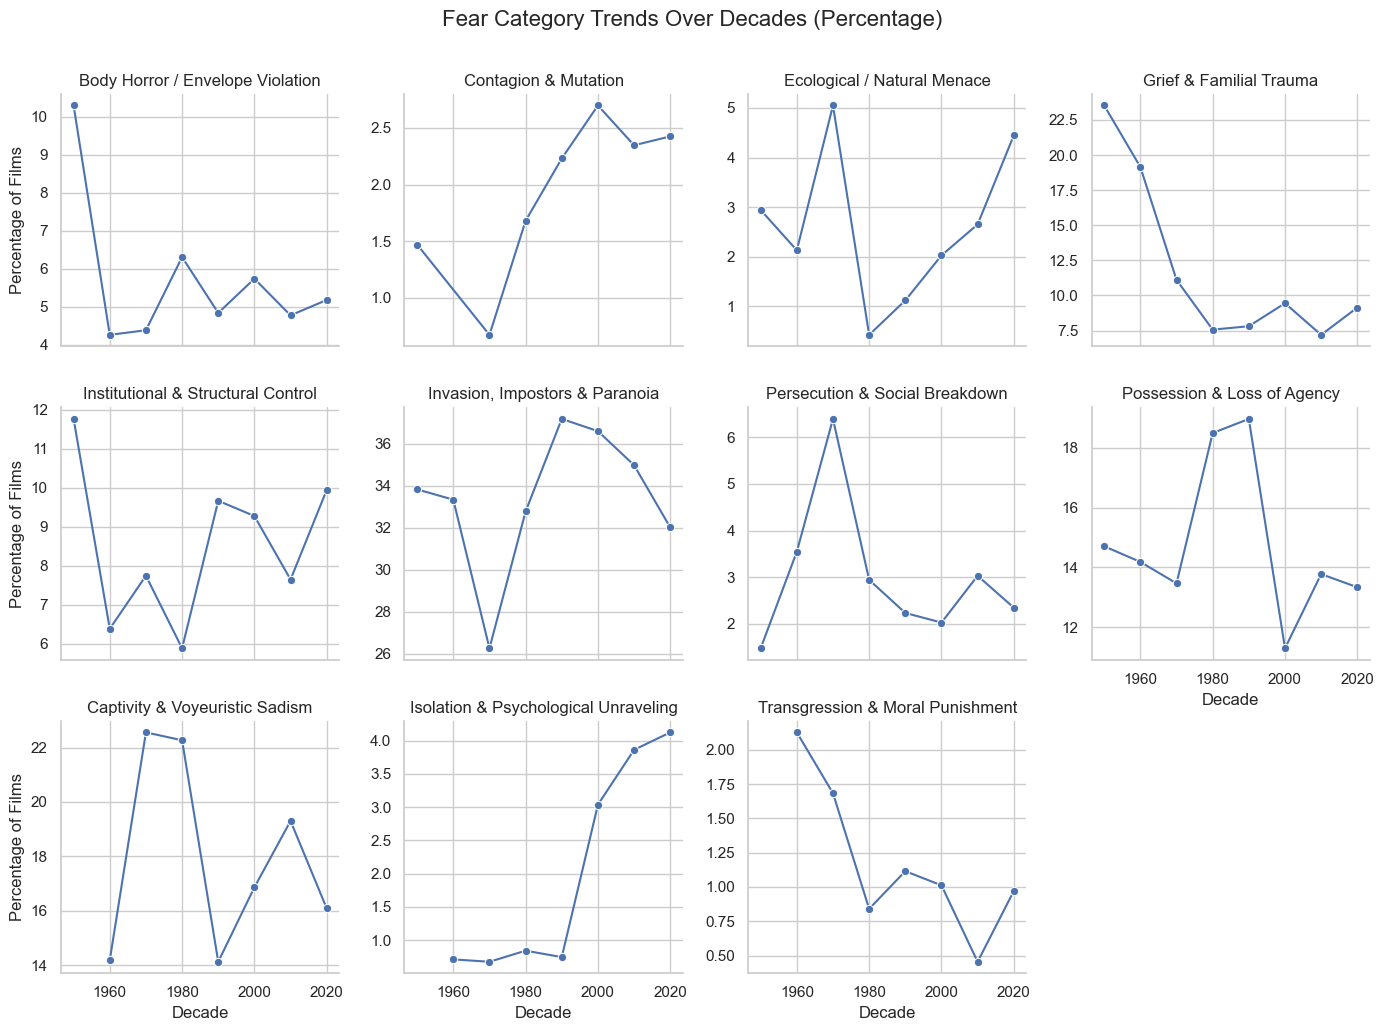

In [123]:
# ======================
# exploratory plots
# ======================

fear_over_time = (
    df_filtered
    .groupby([DECADE_COL, CAT_COL])
    .size()
    .reset_index(name="count")
)

# percentage distribution by decade (stacked bars)
pivot_df = fear_over_time.pivot(index=DECADE_COL, columns=CAT_COL, values="count").fillna(0)
percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

ax = percent_df.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="tab20")
ax.set_title("Percentage Distribution of Fear Categories by Decade")
ax.set_xlabel("Decade")
ax.set_ylabel("Percentage of Films")
plt.legend(title="Fear Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# faceted percentage trends per category
totals = fear_over_time.groupby(DECADE_COL)["count"].sum().reset_index(name="total")
pct = fear_over_time.merge(totals, on=DECADE_COL)
pct["percentage"] = 100 * pct["count"] / pct["total"]

g = sns.FacetGrid(pct, col=CAT_COL, col_wrap=4, height=3.5, sharey=False)
g.map_dataframe(sns.lineplot, x=DECADE_COL, y="percentage", marker="o")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Decade", "Percentage of Films")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Fear Category Trends Over Decades (Percentage)", fontsize=16)
plt.show()


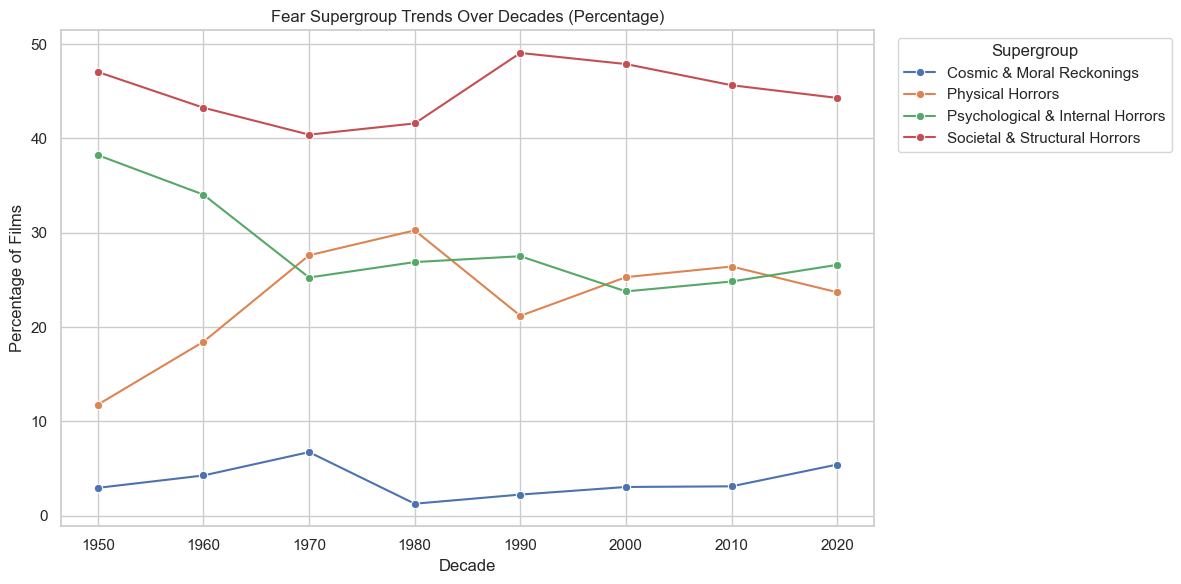

In [124]:
# plotting by supergroups
# we define supergroups mapping to aggregate categories into broader themes

supergroups = {
    "Societal & Structural Horrors": [
        "Invasion, Impostors & Paranoia",
        "Persecution & Social Breakdown",
        "Institutional & Structural Control",
    ],
    "Physical Horrors": [
        "Captivity & Voyeuristic Sadism",
        "Contagion & Mutation",
        "Body Horror / Envelope Violation",
    ],
    "Psychological & Internal Horrors": [
        "Possession & Loss of Agency",
        "Isolation & Psychological Unraveling",
        "Grief & Familial Trauma",
    ],
    "Cosmic & Moral Reckonings": [
        "Ecological / Natural Menace",
        "Transgression & Moral Punishment",
    ],
}

# build a lookup: Fear_Category -> Supergroup
cat_to_super = {cat: sg for sg, cats in supergroups.items() for cat in cats}

# 1) map to supergroup
df_sg = df_filtered.copy()
df_sg["Supergroup"] = df_sg["Fear_Category"].map(cat_to_super)

# 2) count by (decade, supergroup)
supergroup_over_time = (
    df_sg.groupby([DECADE_COL, "Supergroup"])
         .size()
         .reset_index(name="count")
)

# 3) percentages by decade
totals = supergroup_over_time.groupby(DECADE_COL)["count"].sum().reset_index(name="total")
pct = supergroup_over_time.merge(totals, on=DECADE_COL)
pct["percentage"] = 100.0 * pct["count"] / pct["total"]

# sort for tidy plotting
pct = pct.sort_values([DECADE_COL, "Supergroup"]).copy()

# ---- line plot ----
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pct,
    x=DECADE_COL,
    y="percentage",
    hue="Supergroup",
    marker="o"
)
plt.title("Fear Supergroup Trends Over Decades (Percentage)")
plt.xlabel("Decade")
plt.ylabel("Percentage of Films")
plt.legend(title="Supergroup", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()




In [125]:
# creating a csv with the total count for each Fear_Category per decade
decade_fear_counts = (
    df_filtered.groupby(['decade', 'Fear_Category'])
    .size()
    .reset_index(name='count')
)
# saving it to a csv
decade_fear_counts.to_csv("decade_fear_counts.csv", index=False)

In [126]:
# PHASE 4

# Posters download

# What we aim to do in this phase:
#  - read the Phase 3 output CSV
#  - construct full TMDb URLs from relative poster paths
#  - save with the correct file extension (jpg)
#  - skip files already saved and keep a checkpoint of downloaded IDs
# 

# Configuration

CSV_PATH        = Path("horror_data/horror_categorized_FULLSAMPLE_clean_filtered.csv")
OUT_DIR         = Path("artifacts_posters")
POSTERS_DIR     = OUT_DIR / "posters"
CHECKPOINT_JSON = OUT_DIR / "_download_checkpoint.json"
TMDB_BASE       = "https://image.tmdb.org/t/p/original"
COL_ID          = "id"
COL_POSTER      = "poster_path"

# creating the output directories as folders (after checking if they exist already)
OUT_DIR.mkdir(parents=True, exist_ok=True)
POSTERS_DIR.mkdir(parents=True, exist_ok=True)

# ---- load data ----
df = pd.read_csv(CSV_PATH)
df = df[df[COL_POSTER].notna()].copy()

# construct full URL and local path
df["poster_url"]  = TMDB_BASE.rstrip("/") + df[COL_POSTER]
df["poster_file"] = df[COL_ID].astype(str) + ".jpg"
df["local_path"]  = df["poster_file"].apply(lambda s: POSTERS_DIR / s)

# ---- load checkpoint ----
if CHECKPOINT_JSON.exists():
    try:
        checkpoint = set(json.loads(CHECKPOINT_JSON.read_text()).get("downloaded_ids", []))
    except Exception:
        checkpoint = set()
else:
    checkpoint = set()

# ---- download loop ----
downloaded_ids = set(checkpoint)
for _, row in tqdm(df.iterrows(), total=len(df), desc="Downloading posters"):
    mid = str(row[COL_ID])
    if mid in downloaded_ids:
        continue  # skip already done

    url = row["poster_url"]
    out_path = row["local_path"]

    # skip if file exists (from previous run)
    if out_path.exists():
        downloaded_ids.add(mid)
        continue

    try:
        r = requests.get(url, timeout=(5, 30))
        if r.status_code == 200:
            with open(out_path, "wb") as f:
                f.write(r.content)
            downloaded_ids.add(mid)
        else:
            print(f"⚠️  HTTP {r.status_code} for {mid}")
    except Exception as e:
        print(f"Error downloading {mid}: {e}")

    # update checkpoint every 50 images
    if len(downloaded_ids) % 50 == 0:
        CHECKPOINT_JSON.write_text(json.dumps({"downloaded_ids": sorted(list(downloaded_ids))}, indent=2))

# ---- final checkpoint save ----
CHECKPOINT_JSON.write_text(json.dumps({"downloaded_ids": sorted(list(downloaded_ids))}, indent=2))

print(f"Done. Posters OK: {len(downloaded_ids)} / {len(df)}")
print(f"Saved under: {POSTERS_DIR.resolve()}")


Done. Posters OK: 4085 / 4085
Saved under: /Users/lara/dataviz-s1/machine-learning/anatomy-of-horror/artifacts_posters/posters
